In [1]:
import pandas as pd
import numpy as np
import random 
import datetime
import timeit
import matplotlib.pyplot as plt

In [2]:
#Part 1
#Reading files and creating required dataframes
xls = pd.ExcelFile(r"C:\Users\Devadath\Desktop\Gorilla Test\data.xlsx")
forcast_consum = pd.read_excel(xls, 'Forecasted Consumption', index_col ='Meter ID')
meter_list = pd.read_excel(xls, 'Meter List', index_col = 'Meter ID')
rates = pd.read_excel(xls, 'Rates', index_col = 'Exit Zone')

rates = rates.fillna(np.inf) #Setting upper bounds to infinity

total_cost_per_meter = list()
total_consum = list()
meterid = list()

for i, row in meter_list.iterrows(): #For every Meter ID
    ez = meter_list.loc[i, 'Exit Zone'] #Identify the Exit Zone
    aq = meter_list.loc[i, 'Annual Quantity (kWh)'] #Identify the Annual Quantity
    
    reqexrates = rates.loc[ez] #Find the rate ranges for that Exit Zone
    
    #Find the applicable value from the range
    req_date_range = reqexrates.loc[(reqexrates['Annual Quantity (Max)'] > aq) & (reqexrates['Annual Quantity (Min)'] < aq)] 
    req_date_range = req_date_range.reset_index()
    forcast_consum_req = forcast_consum.loc[i] #Find the Consumption readings of the given Meter
    forcast_consum_req = forcast_consum_req.reset_index()
    
    rate_per_date = list()
    k = 0
    for j, row in forcast_consum_req.iterrows(): #Price at a given date
        
        if (forcast_consum_req.loc[j, 'Date'] >= req_date_range.loc[k, 'Date']) & (forcast_consum_req.loc[j, 'Date'] < req_date_range.loc[k+1, 'Date']):
            rate_per_date.append(req_date_range.loc[k, 'Rate (p/kWh)'])
        else:
            k = k+1
            rate_per_date.append(req_date_range.loc[k, 'Rate (p/kWh)'])
            
    total_cost_per_meter.append(sum(forcast_consum_req['kWh']*rate_per_date/100))
    total_consum.append(sum(forcast_consum_req['kWh']))
    meterid.append(i)
    
total_cost_per_meter = [round(num, 2) for num in total_cost_per_meter] #Rounding up for 2 decimal spots
total_consum = [round(num, 2) for num in total_consum]

part1 = pd.DataFrame(list(zip(meterid, total_consum, total_cost_per_meter)), columns = ['Meter ID', 'Total Estimated Consumption (kWh)', 'Total Cost (£)'])
part1 = part1.set_index("Meter ID")

print (part1)

            Total Estimated Consumption (kWh)  Total Cost (£)
Meter ID                                                     
1000000603                            24674.0            8.27
10588707                             122450.0           28.50
10626610                             303558.0           88.24


In [3]:
#Part 2
def part2(rates, num = random.randint(1, 100)):  #Number of meters can be specified. If not, random between 1 and 100
    rates = rates.reset_index()
    ez_unique_list = set(rates['Exit Zone'])
    
    mid_list = list(np.random.randint(low = 1, high = 999999999, size = num)) #Random Meter numbers
    ez_locs = list(np.random.randint(low = 1, high = len(ez_unique_list), size = num)) #Random Zones  for the meters
    ez_list = [list(ez_unique_list)[i] for i in ez_locs]  
    aq_list = random.sample(range(1, 999999), num) #Random AQs
    part2 = pd.DataFrame(list(zip(mid_list, ez_list, aq_list)), columns = ['Meter ID', 'Exit Zone', 'Annual Quantity (kWh)'])
    
    return part2

In [4]:
#Part 3
def part3(meteridlist, s_date, s_month, s_year, e_date, e_month, e_year):
    st_date = datetime.date(s_year, s_month, s_date)
    en_date = datetime.date(e_year, e_month, e_date)
    
    everyday = pd.date_range(st_date, en_date, freq = 'd')
    part3 = pd.DataFrame(columns = ['Date', 'Meter ID', 'kWh'])
    
    for i in meteridlist:
        meterid = [i]*len(everyday)
        consump = list(np.random.randint(low = 1, high = 999, size = len(everyday)))
        temp = pd.DataFrame(list(zip(everyday, meterid, consump)), columns = ['Date', 'Meter ID', 'kWh'])
        part3 = pd.concat([part3, temp])

    return part3

Text(0.5, 1.0, 'Benchmarking wrt number of meters')

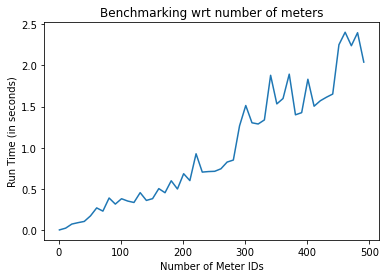

In [5]:
#Part 4 
#Since the problem statement doesn't suggest inputting rates table, an assumption of constant rate is considered 
def part4(forcast_consum, meter_list, rate):
    forcast_consum = forcast_consum.set_index('Meter ID')
    meter_list = meter_list.set_index('Meter ID')
    
    total_cost_per_meter = list()
    total_consum = list()
    meterid = list()    

    for i, row in meter_list.iterrows():
    
        forcast_consumreq = forcast_consum.loc[i]
        forcast_consumreq = forcast_consumreq.reset_index()
        
        total_cost_per_meter.append(sum(pd.Series(forcast_consumreq['kWh'])*rate/100))
        total_consum.append(sum(forcast_consumreq['kWh']))
        meterid.append(i)
        
    total_cost_per_meter = [round(num, 2) for num in total_cost_per_meter] #Rounding up for 2 decimal spots
    total_consum = [round(num, 2) for num in total_consum]
    
    part4 = pd.DataFrame(list(zip(meterid, total_consum, total_cost_per_meter)), columns = ['Meter ID', 'Total Estimated Consumption (kWh)', 'Total Cost (£)'])
    part4 = part4.set_index("Meter ID")
    
    return part4

#Benchmarking
time_meter = list()
num_meterids = np.arange(1, 500, 10) #Complexity wrt number of meters. Used forcasted data of 3 years

for i in num_meterids: 
    meter_list_new = part2(rates, i)
    forcast_consum_new = part3(meter_list_new['Meter ID'], 1, 1, 2020, 31, 12, 2022)
    
    start_time = timeit.default_timer()
    part4(forcast_consum_new, meter_list_new, 0.0287) #A constant rate(p/kWh) of 0.0287 is used
    time_meter.append(timeit.default_timer() - start_time)
    
numids_time_df = pd.DataFrame(list(zip(num_meterids, time_meter)), columns = ['Number of Meter IDs', 'Run Time (in seconds)'])

plt.plot(num_meterids, time_meter)
plt.xlabel('Number of Meter IDs')
plt.ylabel('Run Time (in seconds)')
plt.title('Benchmarking wrt number of meters')

Text(0.5, 1.0, 'Benchmarking wrt period length')

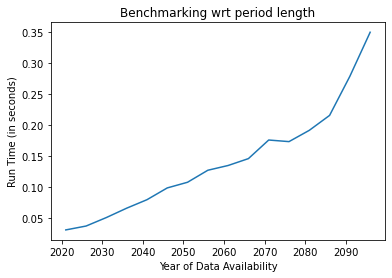

In [6]:
time_fcyears = list()
num_years = np.arange(2021, 2100, 5) #Complexity wrt increasing time. Used 10 meter ids

for i in num_years: 
    meter_list_new = part2(rates, 10)
    forcast_consum_new = part3(meter_list_new['Meter ID'], 1, 1, 2020, 31, 12, i)
    
    start_time = timeit.default_timer()
    part4(forcast_consum_new, meter_list_new, 0.0287) #A constant rate(p/kWh) of 0.0287 is used
    time_fcyears.append(timeit.default_timer() - start_time)
    
numyears_time_df = pd.DataFrame(list(zip(num_years, time_fcyears)), columns = ['Number of Meter IDs', 'Run Time (in seconds)'])

plt.plot(num_years, time_fcyears)
plt.xlabel('Year of Data Availability')
plt.ylabel('Run Time (in seconds)')
plt.title('Benchmarking wrt period length')

#Part 5

As can be seen from the graphs of part 4, the run time of the function grows linearly with respect to the number of meter ids. Also, the run time of the function grows linearly with respect to the amount of forecasted data available. 

The process of calculation is fairly simple. Hence, it is difficult to find significant improvements. However, one change can be made based on the need and availability of time and space. In this case, the dataset of 'rates' is inputted into the main function and is iterated for every meter id to find the correct required rate based on the given date. However, this increases the computation time while keeping the memory consumption to a minimum. This is acceptable as the size of the data set is low in this case and the run times are fast. In case the program is supposed to run on large datasets, the rates dataset can be split into small datasets or even variables and can be stored separately. This will help in the program in running faster as the required variable can be extracted faster. The difference in the program itself will follow along the lines of difference between part 1 and part 4 of this code. It's a matter of time complexity vs memory/space availability. 